In [1]:
import sys
print(sys.prefix)  # Menampilkan path environment aktif

c:\Jatmiar Folder\python-project\Prediksi Konsumsi Energi Listrik\.venv


In [2]:
#!pip install pandas

In [3]:
#!pip install matplotlib seaborn

In [4]:
#!pip install tensorflow scikit-learn

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv("C:\Jatmiar Folder\python-project\Prediksi Konsumsi Energi Listrik\Dataset(1).csv", sep=";")
df.head()

,no,tanggal,konsumsi(kwh)
0,1,30/01/2018,23543455
1,2,28/02/2018,21698806
2,3,30/03/2018,24374770
3,4,30/04/2018,24071263
4,5,30/05/2018,25530256


In [8]:
df.dtypes

no                int64
tanggal          object
konsumsi(kwh)     int64
dtype: object

In [9]:
df.tanggal = pd.to_datetime(df.tanggal)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   no             63 non-null     int64         
 1   tanggal        63 non-null     datetime64[ns]
 2   konsumsi(kwh)  63 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.6 KB


In [11]:
df.shape

(63, 3)

In [12]:
# Mengecek data kosong
df.isnull().sum()
# Mengecek data duplikat
df.duplicated().sum()

np.int64(0)

In [13]:
# Menampilkan deskripsi data
display(df["konsumsi(kwh)"].describe())

count    6.300000e+01
mean     2.883702e+07
std      3.251333e+06
min      2.169881e+07
25%      2.568833e+07
50%      2.978734e+07
75%      3.125809e+07
max      3.583545e+07
Name: konsumsi(kwh), dtype: float64

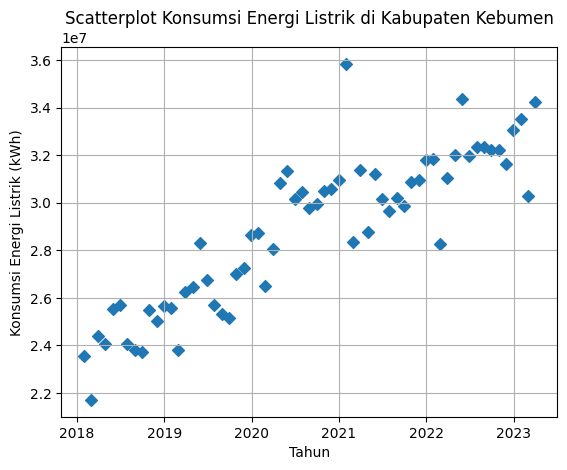

In [14]:
# Membuat Scatterplot
plt.Figure(figsize=(18,10))

plt.scatter(x=df["tanggal"], y=df["konsumsi(kwh)"], marker="D")
plt.grid(True)
plt.title("Scatterplot Konsumsi Energi Listrik di Kabupaten Kebumen")
plt.xlabel("Tahun")
plt.ylabel("Konsumsi Energi Listrik (kWh)")
plt.show()

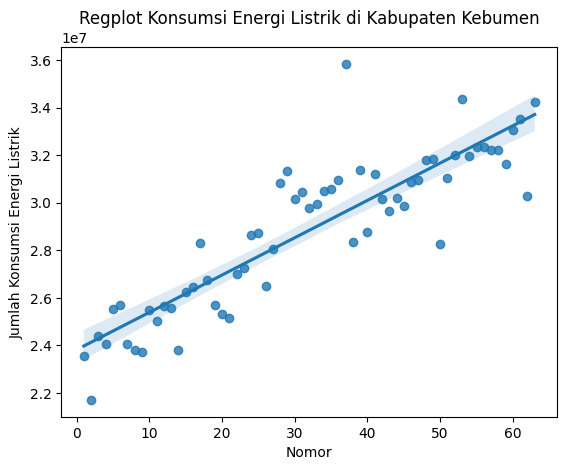

In [15]:
# Membuat regplot
sns.regplot(data=df, x="no", y="konsumsi(kwh)")
plt.title("Regplot Konsumsi Energi Listrik di Kabupaten Kebumen")
plt.xlabel("Nomor")
plt.ylabel("Jumlah Konsumsi Energi Listrik")
plt.show()

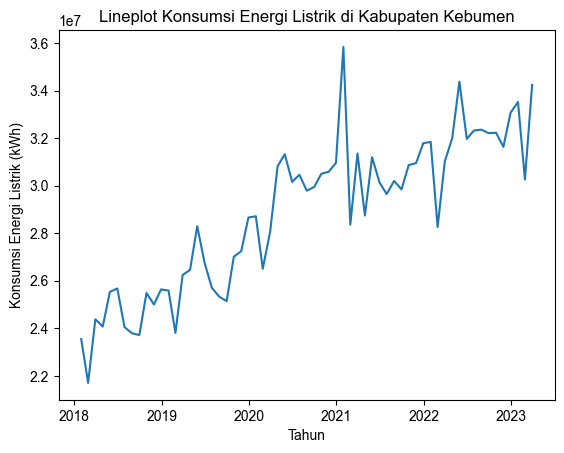

In [16]:
# Membuat Lineplot
plt.Figure(figsize=(16,8))
ax = sns.lineplot(data=df,
             x=df["tanggal"],
             y=df["konsumsi(kwh)"],
             markers="o",
             dashes=True)
sns.set_style("whitegrid")
ax.set_title("Lineplot Konsumsi Energi Listrik di Kabupaten Kebumen")
ax.set(xlabel="Tahun", ylabel="Konsumsi Energi Listrik (kWh)")
plt.show()

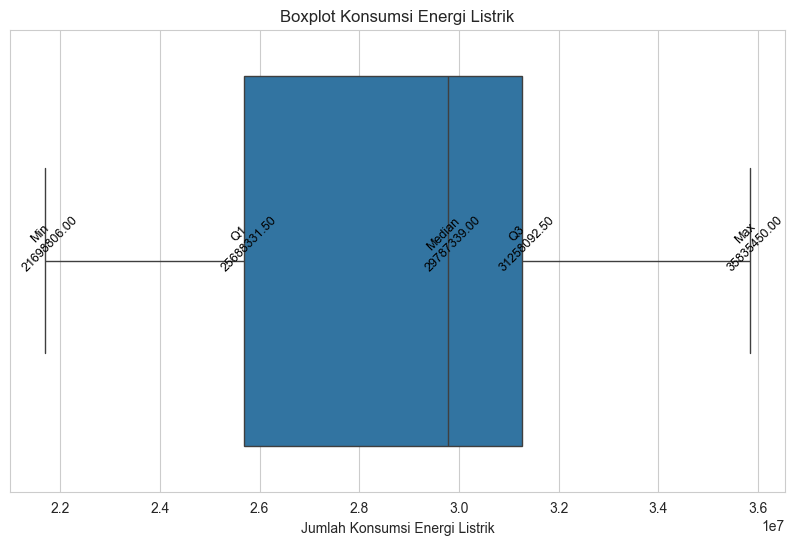

In [19]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x=df["konsumsi(kwh)"])
plt.title("Boxplot Konsumsi Energi Listrik")

# Menambahkan nilai-nilai statistik pada plot
desc = df["konsumsi(kwh)"].describe()
stat_labels = ['Min', 'Q1', 'Median', 'Q3', 'Max']
stat_values = [desc['min'], desc['25%'], desc['50%'], desc['75%'], desc['max']]

for val, label in zip(stat_values, stat_labels):
    plt.text(val, 0.02, f'{label}\n{val:.2f}', ha='center', color='black', fontsize=9, rotation=45)

plt.xlabel("Jumlah Konsumsi Energi Listrik")
plt.show()
